In [1]:
import graph_tool.all as gt
import numpy as np
import numpy.random as rnd
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

変数を設定

・S：未感染者

・I：感染者

・R：免疫者

In [2]:
S = 0
I = 1
R = -1

確率を設定

・感染確率（S → I）：x

・回復率（I → R）：r

In [3]:
x = 0.1
r = 0.1

SIRモデルの関数定義

In [4]:
def SIR():
    # 全ノードをランダムに並べ替える
    vs = list(G.vertices())
    rnd.shuffle(vs)
    # 並べ替えたノードリストを走査し状態更新を行う
    for v in vs:
        if state[v] == I:  # 状態が 'I' の場合
            # 隣接ノードを取得
            ns = list(v.out_neighbors())
            for w in ns:
                # 隣接ノードが 'S' 状態かどうかを確認し、確率 x で 'I' 状態に変更
                if state[w] == S and rnd.random() < x:
                    state[w] = I
            # 状態が確率 r で 'R' 状態に変更
            if rnd.random() < r:
                state[v] = R
    return

例：BAモデルに対するSIRを行ってみる

Barabasi-Albertモデル

In [5]:
# SFネットワーク生成関数
def ba(n, m, seed=None): 
    # 乱数生成のシードを設定可能
    if seed is not None:
        np.random.seed(seed=seed)
    
    m0 = m + 1  # 初期次数:m + 1
    g = gt.Graph(m0,directed = False)  # 初期のスター型グラフを生成
    g.add_edge_list([(0, i) for i in range(1, m0)])  # 初期のリンクの追加
    initial_edges = list(g.edges()) # 初期のリンクの一覧を生成
    node_list = list(range(m0)) #初期のノードの一覧を生成
    
    # ノードを追加し、リンクを次数に比例して追加していく
    for i in range(m0, n):
        g.add_vertex()  # ノードを追加
        # 現在のネットワークの各ノードの次数を計算しk_array_before配列に保管
        K_array_before = np.array([v.out_degree() for v in g.vertices() if v.out_degree() != 0])  # 次数の配列 全頂点の次数（次数が0のノードを除外）
        
#      -----------------------------
        K_array = K_array_before**1
#      -----------------------------
        
        for j in range(m):
            # 次数に比例した確率ベクトルを生成
            s = np.sum(K_array)
            parray = K_array / s

            # 次数に比例した確率で既存のノードを選び、エッジとする
            new = np.random.choice(node_list, p=parray)
            g.add_edge(g.vertex(i), g.vertex(new))
            
            K_array[node_list.index(new)] = 0.
        
        node_list.append(i)
    
    for edge in initial_edges:
        g.remove_edge(edge)
    return g

作成するネットワークの要素

In [6]:
# ノード数
n = 1000

# 新規ノードが接続するノード数
m = 2

# 異なる構造のBAモデルをいくつ作る？
num_samples = 10

baグラフを作成

In [7]:
# BAネットワークを生成
ba_graphs = []
for _ in range(num_samples):
    ba_g = ba(n, m)
    ba_graphs.append(ba_g)

シミュレーションの回数

In [8]:
# 何回感染シミュレーションを繰り返すのか？
max_itr = 100

# 1つのBAモデルに対して、一連の感染シミュレーションの平均を何回でとるのか？
num_iterations = 10

# 初期感染者の数と、取得する値の間隔を指定する
v_change_range = range(100, 901, 100)

シミュレーション内容

In [ ]:
            # 状態初期化、ランダムに初期感染者を選ぶ場合
            for v in G.vertices():
                state[v] = S
            nodes = list(G.vertices())
            random.shuffle(nodes)
            for v in nodes[:v_change]:
                state[v] = I
                
            # 状態初期化、ノードの次数の高い順に初期感染者を選ぶ場合
            for v in G.vertices():
                state[v] = S
            nodes = list(G.vertices())
            nodes_degrees = [(v, G.vertex(v).in_degree() + G.vertex(v).out_degree()) for v in nodes]
            nodes_sorted = [v for v, _ in sorted(nodes_degrees, key=lambda x: x[1], reverse=True)]
            for v in nodes_sorted[:v_change]:
                state[v] = I
                
            # 状態初期化、ノードの次数の低い順に初期感染者を選ぶ場合
            for v in G.vertices():
                state[v] = S
            nodes = list(G.vertices())
            nodes_degrees = [(v, G.vertex(v).in_degree() + G.vertex(v).out_degree()) for v in nodes]
            nodes_sorted = [v for v, _ in sorted(nodes_degrees, key=lambda x: x[1])]
            for v in nodes_sorted[:v_change]:
                state[v] = I

In [9]:
Result_R = []
Result_time = []

for v_change in tqdm(v_change_range):
    print(f"v_change = {v_change}開始")
    result_list = []
    time_list = []
    
    for ba_model in ba_graphs:
        S_avg = []
        X_avg = []
        R_avg = []
        result = []
        time = []
        
        # num_iterations分、平均をとる
        for i in range(num_iterations):
            G = ba_model
            locals()[f'G{i}'] = G.copy()

        for j in range(num_iterations):
            G = locals()[f'G{j}']
            state = G.new_vertex_property("int")
                
            # 状態初期化、ノードの次数の高い順に初期感染者を選ぶ場合
            for v in G.vertices():
                state[v] = S
            nodes = list(G.vertices())
            nodes_degrees = [(v, G.vertex(v).in_degree() + G.vertex(v).out_degree()) for v in nodes]
            nodes_sorted = [v for v, _ in sorted(nodes_degrees, key=lambda x: x[1], reverse=True)]
            for v in nodes_sorted[:v_change]:
                state[v] = I
                
            R_max = None
            R_stop = None
            suscept_st = []
            infect_st = []
            recov_st = []

            suscept_st.append(list(state.a).count(S))
            infect_st.append(list(state.a).count(I))
            recov_st.append(list(state.a).count(R))

            # シミュレーションの実行
            for updt in range(max_itr):
                SIR()
                suscept_st.append(list(state.a).count(S))
                infect_st.append(list(state.a).count(I))
                recov_st.append(list(state.a).count(R))
                
                # 感染が停止した時の操作
                if 0 in infect_st:
                    i = infect_st.index(0)
                    R_max = recov_st[i]
                    R_stop = i
                    result.append((R_max))
                    time.append((R_stop))
                    break
                    
        result_list.append(np.mean(result, axis=0))
        time_list.append(np.mean(time, axis=0))
    
    RM = np.mean(result_list, axis=0)
    RS = np.mean(time_list, axis=0)
    Result_R.append(RM)
    Result_time.append(RS)
    print('シミュレーション完了')

  0%|                                                                                                                                                                                | 0/9 [00:00<?, ?it/s]

v_change = 100開始


 11%|██████████████████▋                                                                                                                                                     | 1/9 [00:39<05:16, 39.55s/it]

シミュレーション完了
v_change = 200開始


 22%|█████████████████████████████████████▎                                                                                                                                  | 2/9 [01:19<04:37, 39.59s/it]

シミュレーション完了
v_change = 300開始


 33%|████████████████████████████████████████████████████████                                                                                                                | 3/9 [01:58<03:57, 39.58s/it]

シミュレーション完了
v_change = 400開始


 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                             | 4/9 [02:37<03:16, 39.33s/it]

シミュレーション完了
v_change = 500開始


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 5/9 [03:16<02:36, 39.11s/it]

シミュレーション完了
v_change = 600開始


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 6/9 [03:55<01:57, 39.04s/it]

シミュレーション完了
v_change = 700開始


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 7/9 [04:33<01:17, 38.84s/it]

シミュレーション完了
v_change = 800開始


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 8/9 [05:12<00:38, 38.79s/it]

シミュレーション完了
v_change = 900開始


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [05:51<00:00, 39.07s/it]

シミュレーション完了


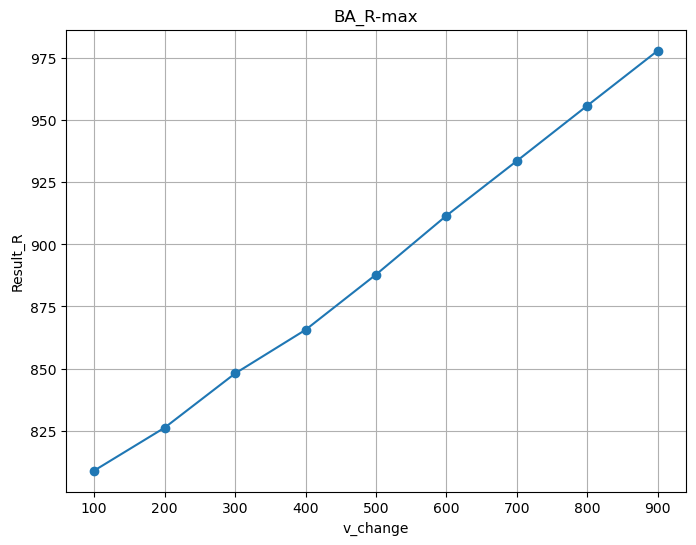

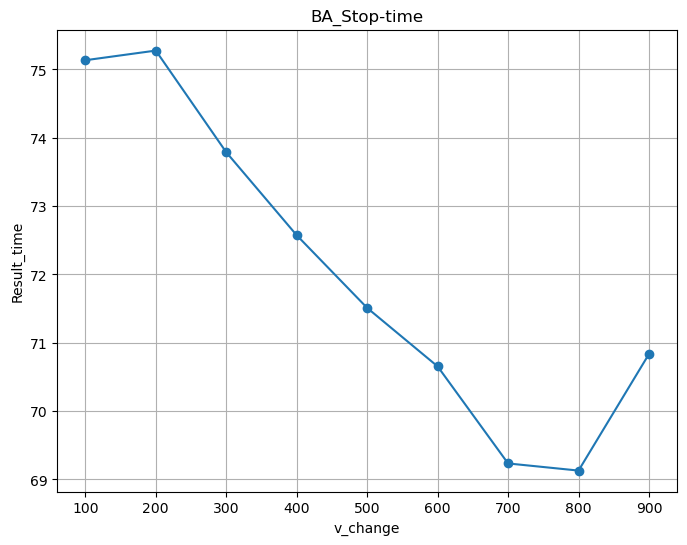

In [10]:
# Plotting Result_R
plt.figure(figsize=(8, 6))
plt.plot(v_change_range, Result_R, marker='o')
plt.xlabel('v_change')
plt.ylabel('Result_R')
plt.title('BA_R-max')
plt.grid(True)
plt.show()

# Plotting Result_time
plt.figure(figsize=(8, 6))
plt.plot(v_change_range, Result_time, marker='o')
plt.xlabel('v_change')
plt.ylabel('Result_time')
plt.title('BA_Stop-time')
plt.grid(True)
plt.show()